In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', 200, 'display.max_rows', 100)

In [2]:
TAU_RANGE = 35
owid = pd.read_csv('./data/1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('./data/2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid.loc[:,["location","date","reproduction_rate",'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index']]

#reproduction_i is the reproduction rate after i days.
reproduction_measures = ['reproduction_rate']
for i in range(1,TAU_RANGE):
    reproduction_measures = reproduction_measures + ['reproduction_'+str(i)]
    df['reproduction_'+str(i)] = df.groupby('location')['reproduction_rate'].shift(-i)

In [3]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]

# adding a column of all ones for beta_avg
# try:
#     df.insert(len(df.columns), "beta_avg", 1)
# except ValueError:  # ValueError thrown if df already has that column
#     pass

# initialize a column for each country type with all 0s
# for country in eu_response["Country"].unique():
#     try:
#         df.insert(len(df.columns), country, 0)
#     except ValueError:  # ValueError thrown if df already has that column
#         pass
# # set the corresponding country to 1
# for _, row in df.iterrows():
#     df.loc[ df["location"] == row["location"] , row["location"]] = 1


# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
for _, row in eu_response.iterrows():
    df.loc[ ( df["location"] == row["Country"] ) & ( df["date"] >= row["date_start"] ) & ( df["date"] < row["date_end"] ), row["Response_measure"]] = 1

In [4]:
# time from 2020-3-24 
df = df[pd.to_datetime(df.date) >= pd.to_datetime('2020-03-24')]
df['t'] = pd.to_numeric((pd.to_datetime(df.date)-pd.to_datetime('2020-03-24')).dt.days, downcast='float')
df['t2'] = df['t']**2
df['t3'] = df['t']**3
df['t4'] = df['t']**4
df['t5'] = df['t']**5

# onehot encode country data
df = pd.concat([df,pd.get_dummies(df.location)],axis=1)

# drop old non-numerical location and date
countries = df.location
df = df.drop(['location','date'],axis=1)
df = df.dropna()

# Linear model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [6]:
# We use bootstrap to find the optimal tau and corresponding coefficients
linear_df = df.copy()
B = 1000
linear_result = pd.DataFrame(index = [str(x) for x in range(TAU_RANGE)])

In [7]:
# Randomly sample test and training set.
# This block has high running time.
for b in range(0,B):
    trainl, testl = train_test_split(linear_df, test_size=0.2)
    Xtrainl = trainl[trainl.columns.difference(reproduction_measures)]
    Xtestl = testl[testl.columns.difference(reproduction_measures)]
    test_score = []
    for i in range(0,TAU_RANGE):    
        if i == 0:
            Ytrainl = trainl["reproduction_rate"]
            Ytestl = testl["reproduction_rate"]
        else:
            Ytrainl = trainl["reproduction_"+str(i)]
            Ytestl = testl["reproduction_"+str(i)]
        linear_regressor = LinearRegression()
        linear_regressor.fit(Xtrainl, Ytrainl)
        test_score = test_score + [linear_regressor.score(Xtestl,Ytestl)]
    linear_result['trial'+str(b)] = test_score
linear_result['mean'] = linear_result.mean(axis=1)
linear_result['std'] = linear_result.std(axis=1)

<AxesSubplot:>

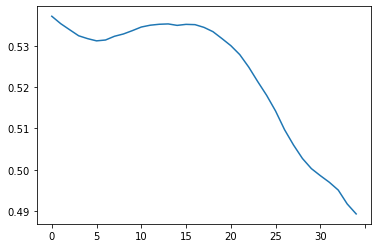

In [8]:
linear_result['mean'].plot()

<AxesSubplot:>

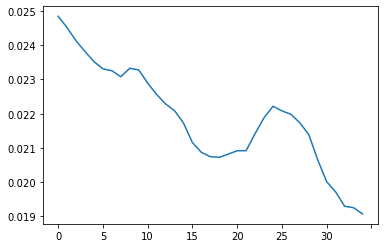

In [11]:
linear_result['std'].plot()

Text(0.5, 1.0, 'Coefficients $\\beta$ for each response_measure')

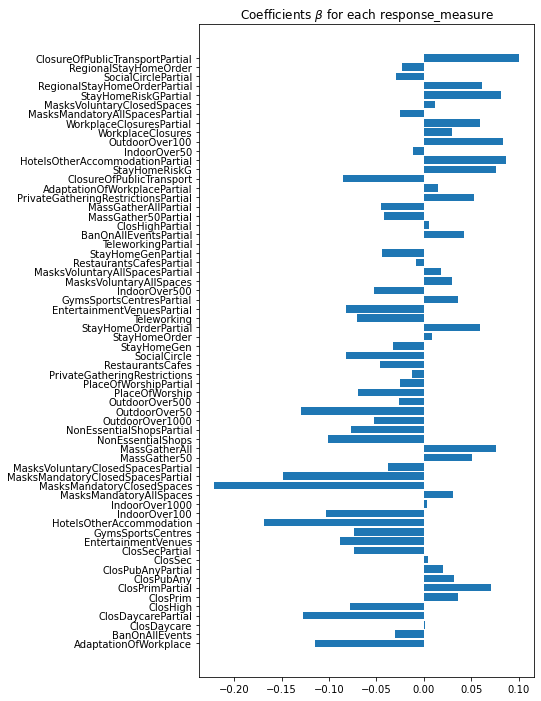

In [13]:
X = linear_df[linear_df.columns.difference(reproduction_measures)]
Y = linear_df['reproduction_14']
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
coefficients = dict(zip(eu_response["Response_measure"].unique(), linear_regressor.coef_))
plt.figure(figsize=(6,12))
plt.barh(y = list(coefficients.keys()), width = coefficients.values())
plt.title("Coefficients $\\beta$ for each response_measure")